In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD   # test trajectory
# import numpy.linalg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.spatial.transform as Rotation
from scipy.spatial import distance

import os
import pickle

from IPython.display import Image
import py3Dmol
dtype = np.float32 

def view_mol(mol):
    v = py3Dmol.view(width=300,height=300)
    v.addModel(mol)
    v.zoomTo()
    model = v.getModel()
    model.setStyle({}, {"stick": {"colorscheme": "cyanCarbon"}})
    return v


def view_mol_i(i):
    print(i)
    atoms = positions[0,i]
    xyz_str = make_xyz(atoms)
    return view_mol(xyz_str)
    
    
atom_names = ["O", "C", "H", "H", "H", "H"]

def make_xyz(_p):
    # _p = positions[i][t]
    n_atoms = len(_p)
    s = f"{n_atoms}\nTitle\n"
    
    for i, xyz in enumerate(_p):
        _an = atom_names[i]
        s += "{} {} {} {}\n".format(_an,xyz[0],xyz[1],xyz[2])
        
    # s += "\n"
        
    return s


def get_dist_matrix(atoms):
    #https://www.kaggle.com/code/rio114/coulomb-interaction-speed-up/notebook
    num_atoms = len(atoms)
    loc_tile = np.tile(atoms.T, (num_atoms,1,1))
    dist_mat = np.sqrt((loc_tile - loc_tile.T)**2).sum(axis=1)
    return dist_mat

def dihedral3(p):
    b = p[:-1] - p[1:]
    b[0] *= -1
    v = np.array( [np.cross(v,b[1]) for v in [b[0], b[2]] ] )
    # Normalize vectors
    v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1,1)
    return np.degrees(np.arccos( v[0].dot(v[1]) ))


def angle(p):
    ba = p[0] - p[1]
    bc = p[2] - p[1]
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    a3 = np.degrees(np.arccos(cosine_angle))
    return a3


def animate_path(traj_path, reps=3):
    traj_str = ""
    for _, i in enumerate(traj_path):
        
        if _ == 0:
            print("Frame\tBond\tAngle\tRMSD")
            prev_fram = i
            rmsd = 0.00
        else:
            rmsd = _2drmsd[i, prev_fram]
            prev_fram = i
        
        print("{}\t{:.2f}\t{:.2f}\t{:.2f}".format(i, CO_bonds[i], 
                                                  COH_angles[i], rmsd))
        atoms = positions[0,i]
        for rep in range(reps):
            xyz_str = make_xyz(atoms)
            traj_str += xyz_str

    view = py3Dmol.view()
    view.addModelsAsFrames(traj_str,'xyz')
    view.setStyle({}, {"stick": {"colorscheme": "cyanCarbon"}})
    view.animate({'loop':'forward'})
    view.zoomTo()
    return view




from anytree import Node, RenderTree

def make_traversal(G, start=0):

    shortest_paths = nx.single_source_dijkstra_path(G, start)

    paths = list(dict(sorted(shortest_paths.items(), key=lambda item: len(item))).values())
    paths.reverse()
    path_visits = [paths[0]]

    for p in paths[1:]:
        path_visits.append(p)

    l = []
    for i in path_visits:
        for j in i:
            l.append(j)

    lengths = [len(x) for x in path_visits]
    path_lengths = { x:[] for x in range(np.min(lengths), np.max(lengths) + 1) }

    max_path_length = max(path_lengths.keys())

    for i, path in enumerate(path_visits):
        path_lengths[len(path)].append(path)

    visited = []    

    for i in range(max_path_length, 0, -1):
        for path in path_lengths[i]:
            if i == 10:
                visited.append(path)
            else:
                __sublist__ = False

                for v in visited:
                    if len(v) > i:
                        if v[i-1] == path[-1]:
                            __sublist__ =  True

                if not __sublist__:
                    visited.append(path)


    seen = []
    for i in visited:
        if i not in seen:
            seen.append(i)

    lst = visited

    def list_to_anytree(lst):
        root_name = lst[0][0]
        root_node = Node(root_name)
        nodes = {root_name: root_node}  # keeping a dict of the nodes
        for branch in lst:
            assert branch[0] == root_name
            for parent_name, node_name in zip(branch, branch[1:]):
                node = nodes.setdefault(node_name, Node(node_name))
                parent_node = nodes[parent_name]
                if node.parent is not None:
                    assert node.parent.name == parent_name
                else:
                    node.parent = parent_node
        return root_node


    anytree = list_to_anytree(lst)
    for pre, fill, node in RenderTree(anytree):
        print(f"{pre}{node.name}")

    return lst, anytree




/home/boittier/miniconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


#  Smooth gradients in high dimensional data 

## 1. Load methanol trajectories (at different temperatures or clustering)

## 2. Calculate the distance matrix (DM) for each conformation

## 3. Use the distance between DMs for the distance measure

In [21]:
# /home/unibas/boittier/MDCM/examples/multi-conformer/ref/scan0
bohr_to_a = 0.529177

In [22]:
comparison = open("rmsd2d/data/scan0.d.cube").readlines()[6:12]
comparison_pos = np.zeros((6,3))
for i in range(6):
    line = [float(x) for x in comparison[i].split()[2:]]
    comparison_pos[i,0] = line[0]*bohr_to_a
    comparison_pos[i,1] = line[1]*bohr_to_a
    comparison_pos[i,2] = line[2]*bohr_to_a
    
comparison_pos

array([[-0.7446076 ,  0.1221023 ,  0.        ],
       [ 0.6582946 , -0.01977058,  0.        ],
       [-1.13129047, -0.75980504,  0.        ],
       [ 1.07797482,  0.98883708,  0.        ],
       [ 1.03020443, -0.54366322,  0.89299942],
       [ 1.03020443, -0.54356321, -0.89299942]])

#  Amber Traj

In [23]:
psf = "/home/boittier/Documents/PhD/parametrization/rmsd2d/pdbs/avg.pdb.c0.pdb"
dcd = "/home/boittier/Documents/PhD/parametrization/rmsd2d/singlerep.dcd"
u = mda.Universe(psf, dcd)
res = u.select_atoms("resname LIG")

traj = u.trajectory
n_frames = len(traj)
n_atoms = len(u.select_atoms('resid 100')._ix)    
n_res = int(len(res)/n_atoms)

#  allocate positions
positions = np.zeros((n_res, n_frames, n_atoms, 3))

# loop frames
for t, ts in enumerate(u.trajectory):
    # loop residues
    for i in range(n_res):
        # save positions
        for i_atom in range(n_atoms):
            # print(u.atoms[i*n_atoms+i_atom].position)
            positions[i][t][i_atom] = u.atoms[i*n_atoms+i_atom].position




In [24]:
traj

<DCDReader /home/boittier/Documents/PhD/parametrization/rmsd2d/singlerep.dcd with 2500 frames of 6 atoms>

In [25]:
res

<AtomGroup with 6 atoms>

In [26]:
n_atoms

6

In [27]:
pos_shape = positions.shape
n_frames = pos_shape[1]
pos_shape

(1, 2500, 6, 3)

In [28]:
# comp_2drms

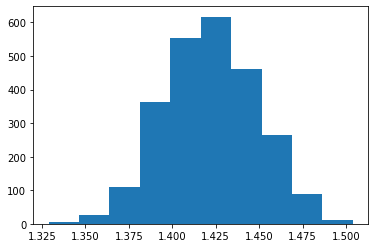

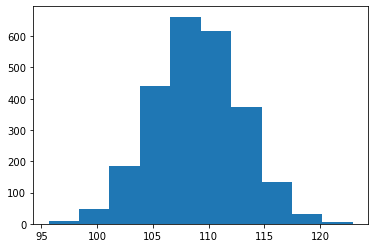

In [29]:
molecules = []
distance_matrices = []
COH_angles = []
CO_bonds = []

comp_dm = get_dist_matrix(comparison_pos)

comp_2drms = []

# n_frames = 2600

for i in range(n_frames):
    _ = positions[0,i]
    molecules.append(_)
    
    dm = get_dist_matrix(_)
    distance_matrices.append(dm)
    
    comp_2drms.append(np.linalg.norm(dm-comp_dm)/len(comp_dm)**2)
    
    np_angle = np.array([_[2], _[0], _[1]])
    COH_angles.append(angle(np_angle))
    CO_bonds.append(distance.euclidean(_[0], _[1]))
    
plt.hist(CO_bonds)
plt.show()

plt.hist(COH_angles)
plt.show()

CO_bonds_copy = CO_bonds.copy()
COH_angles_copy = COH_angles.copy()

In [30]:
print(dm-comp_dm)
print(dm)
print(comp_dm)

[[ 0.          0.82493107  0.09025789  0.47862055 -0.69636565  0.34020526]
 [ 0.82493107  0.          0.42522734  0.14557849 -0.20969126 -0.12150369]
 [ 0.09025789  0.42522734  0.          0.56208638  0.03048081  0.47654541]
 [ 0.47862055  0.14557849  0.56208638  0.          0.60094197 -0.28469592]
 [-0.69636565 -0.20969126  0.03048081  0.60094197  0.          1.46020996]
 [ 0.34020526 -0.12150369  0.47654541 -0.28469592  1.46020996  0.        ]]
[[0.         2.36970615 1.35884809 3.16793776 2.63721132 3.67368221]
 [2.36970615 0.         2.95484686 1.57386637 1.57911062 1.66719818]
 [1.35884809 2.95484686 0.         4.51999378 3.30111694 3.74728155]
 [3.16793776 1.57386637 4.51999378 0.         3.07421207 2.18847418]
 [2.63721132 1.57911062 3.30111694 3.07421207 0.         3.2463088 ]
 [3.67368221 1.66719818 3.74728155 2.18847418 3.2463088  0.        ]]
[[0.         1.54477509 1.2685902  2.6893172  3.33357697 3.33347696]
 [1.54477509 0.         2.52961952 1.42828788 1.78880188 1.788701

In [74]:
indexes = list(range(2500))
ind_sort, rmsd_sort = zip(*sorted(zip(indexes, comp_2drms), key=lambda x: x[1]))

In [75]:
for i in range(10):
    print(ind_sort[i], rmsd_sort[i])

1473 1.59872148828618
637 1.7060997679636538
1678 1.8303806346234008
1141 1.8319500659861456
1443 1.8321979072783503
1418 1.8327140273292268
1278 1.8346961639638304
2290 1.838440826637968
403 1.8625925734760174
834 1.8671910294072922


In [31]:
comp_2drms.index(min(comp_2drms))

1473

In [35]:
# comp_2drms

In [13]:
_2drmsd = np.zeros((n_frames,n_frames))
_2drmsd.shape

for i in range(n_frames):
    for j in range(n_frames):
        if i < j:
            dm1 = distance_matrices[i]
            dm2 = distance_matrices[j]
            _2drmsd[i, j] = np.linalg.norm(dm1-dm2)
            _2drmsd[j, i] = _2drmsd[i, j]
            

(array([9.338800e+04, 6.809360e+05, 9.161120e+05, 1.395390e+06,
        1.487184e+06, 1.166174e+06, 4.295360e+05, 7.037600e+04,
        1.037400e+04, 5.300000e+02]),
 array([0.        , 0.51033031, 1.02066063, 1.53099094, 2.04132125,
        2.55165157, 3.06198188, 3.57231219, 4.0826425 , 4.59297282,
        5.10330313]),
 <BarContainer object of 10 artists>)

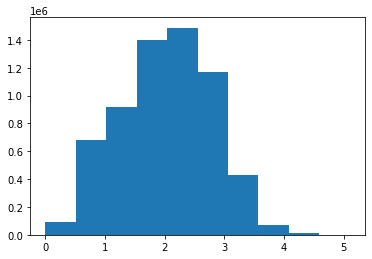

In [14]:
plt.hist(_2drmsd.flatten())

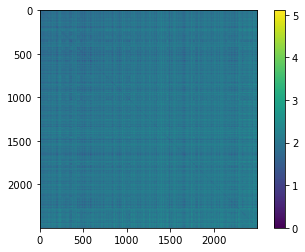

In [15]:
plt.imshow(_2drmsd, cmap='viridis')
plt.colorbar()

0.5627586306872937


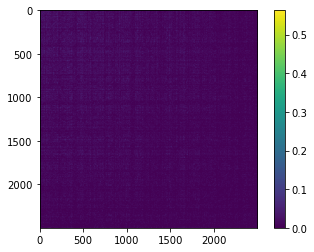

In [367]:
cut_off = np.where(_2drmsd==0, 100, _2drmsd).min(axis=1).max()
cut_off = cut_off*0.5
print(cut_off)
cleaned = np.where(_2drmsd<cut_off, _2drmsd, 0)

plt.imshow(cleaned, cmap='viridis')
plt.colorbar()

In [462]:
import networkx as nx
# !pip install pydot
# ! pip install pygraph
# !pip install graphviz
G = nx.from_numpy_matrix(cleaned)


In [463]:
#  remove any disconnected subgraphs
nodes = max(nx.connected_components(G), key=len)
H = nx.subgraph(G, nodes)


In [464]:
MAX_EDGES = 50

edges_to_remove = []

nodes = H.nodes

for node in nodes:

    edges = [edge for edge in H.edges(node)]

    if len(edges) > MAX_EDGES:

        weights = [H.get_edge_data(*i)["weight"] for i in edges]
        sorted_weights, sorted_edges = zip(*sorted(zip(weights, edges), key=lambda x: x[0]))
        limited_edges = sorted_edges[MAX_EDGES:]
        edges_to_remove.append(limited_edges)
        # edges_to_remove.append([(b,a) for a,b in limited_edges])

H = H.copy()
for edge in edges_to_remove:
    H.remove_edges_from(edge)
            

In [465]:
# H.remove_node(2490)
# H.remove_node(1337)

In [466]:
# subgraphs = list(nx.connected_components(H))
# for i in range(len(subgraphs)):
#     print(len(subgraphs[i]))

In [467]:
# nodes = list(nx.connected_components(H))[0]
# # dfs_edges(G, source=None, depth_limit=None)
# # H = nx.dfs_tree(H, source=1, depth_limit=1)
# # nodes = H.nodes
# H = nx.subgraph(H, nodes)

nodes = max(nx.connected_components(H), key=len)
H = nx.subgraph(H, nodes)


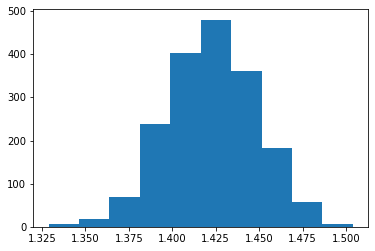

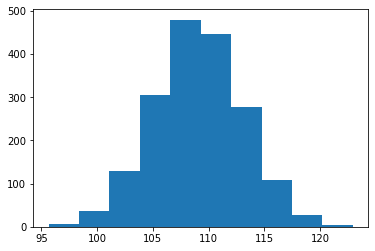

In [468]:
molecules = []
COH_angles = {}
CO_bonds = {}
COH = []
CO = []
RMSD_to_ref = []

ref = 1473


for i in nodes:
    _ = positions[0,i]
    molecules.append(_)
    np_angle = np.array([_[2], _[0], _[1]])
    COH.append(angle(np_angle))
    COH_angles[i] = angle(np_angle)
    CO.append(distance.euclidean(_[0], _[1]))
    CO_bonds[i] = distance.euclidean(_[0], _[1])
    # RMSD_to_ref.append(_2drmsd[ref,i])
    RMSD_to_ref.append(comp_2drms[i])
    
plt.hist(CO)
plt.show()

plt.hist(COH)
plt.show()

CO_bonds_copy = CO_bonds.copy()
COH_angles_copy = COH_angles.copy()

# pos = nx.spring_layout(H)
# pos = nx.nx_pydot.graphviz_layout(H, prog="twopi", root=1)

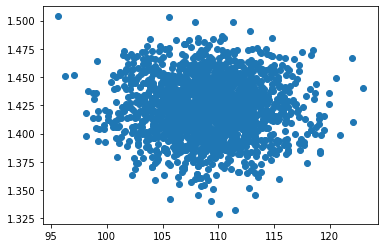

In [489]:
plt.scatter(COH_angles.values(), CO_bonds.values())

In [469]:
pos = nx.kamada_kawai_layout(H)
# pos = nx.spring_layout(H)


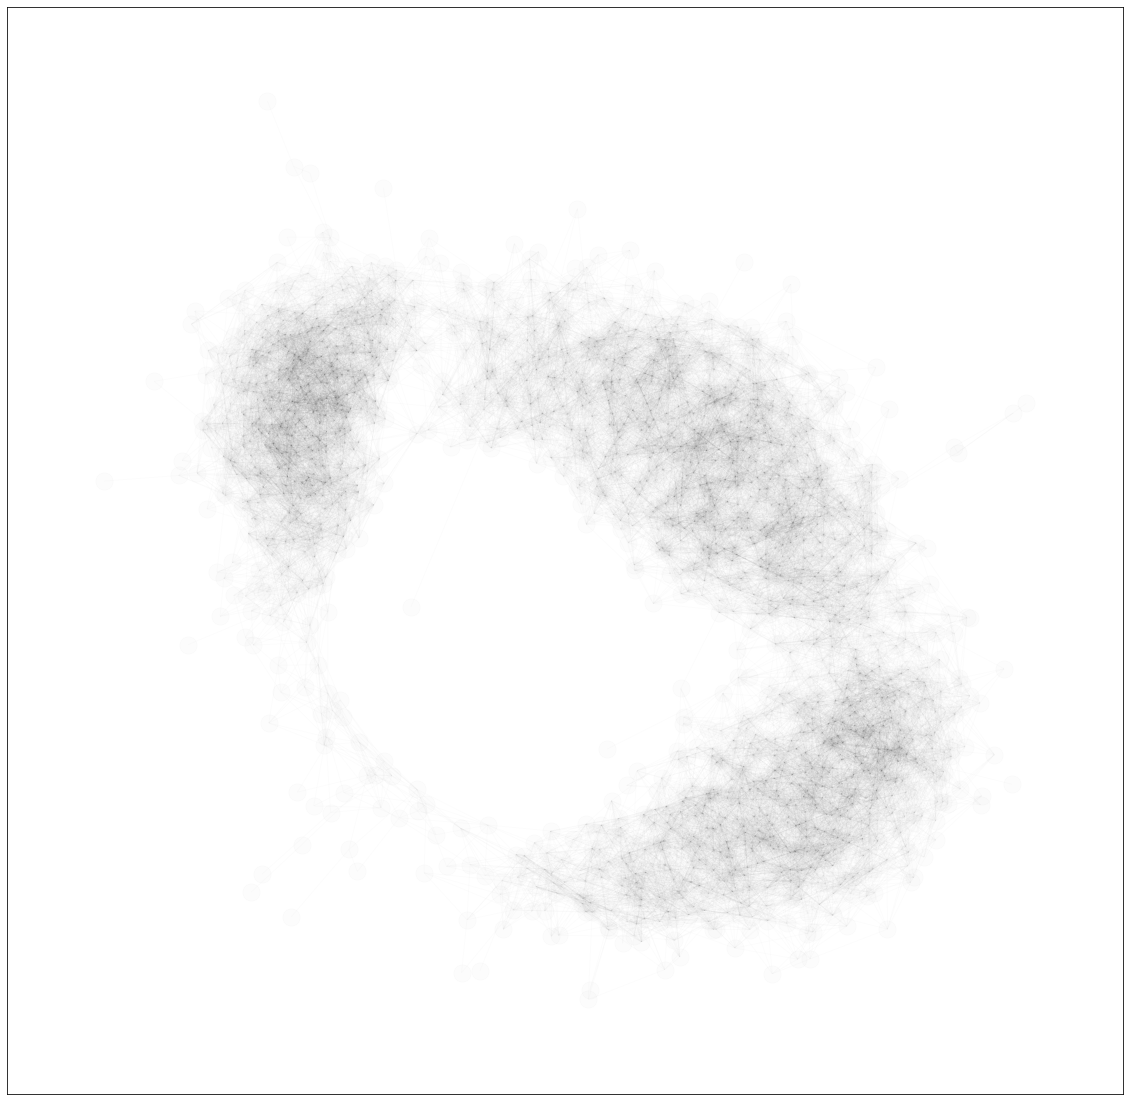

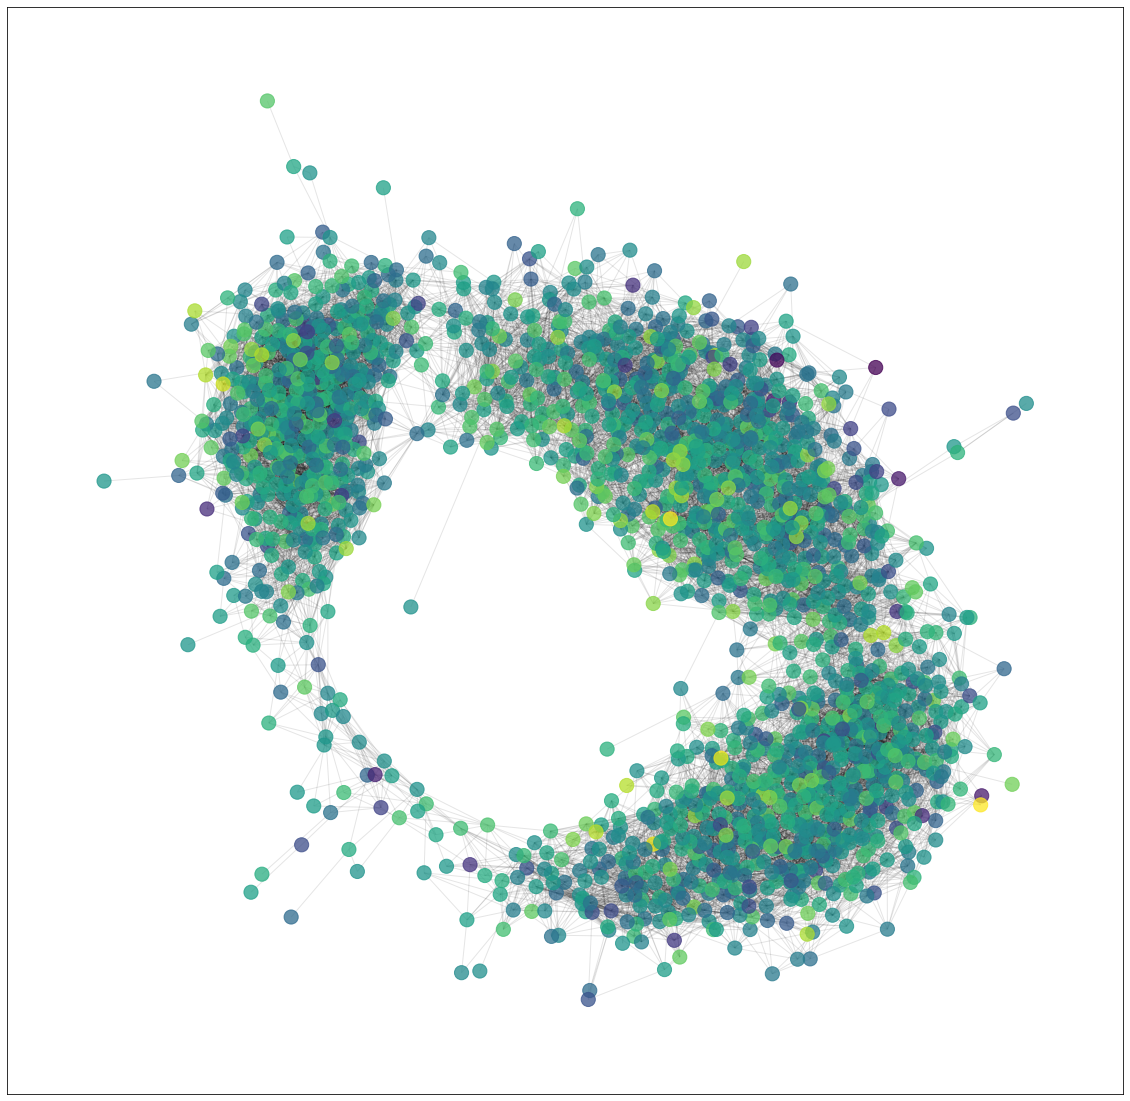

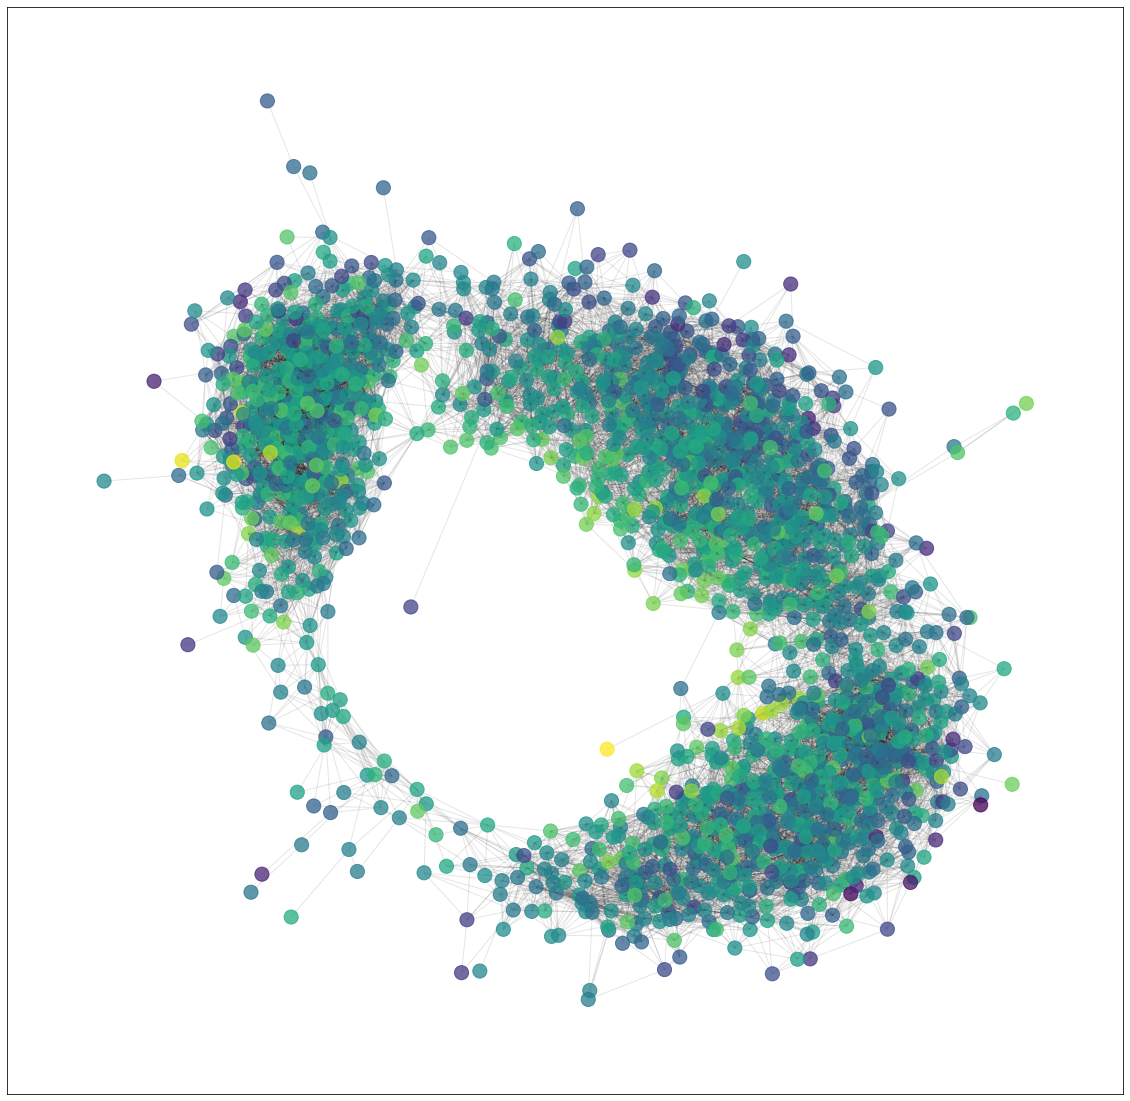

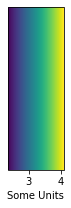

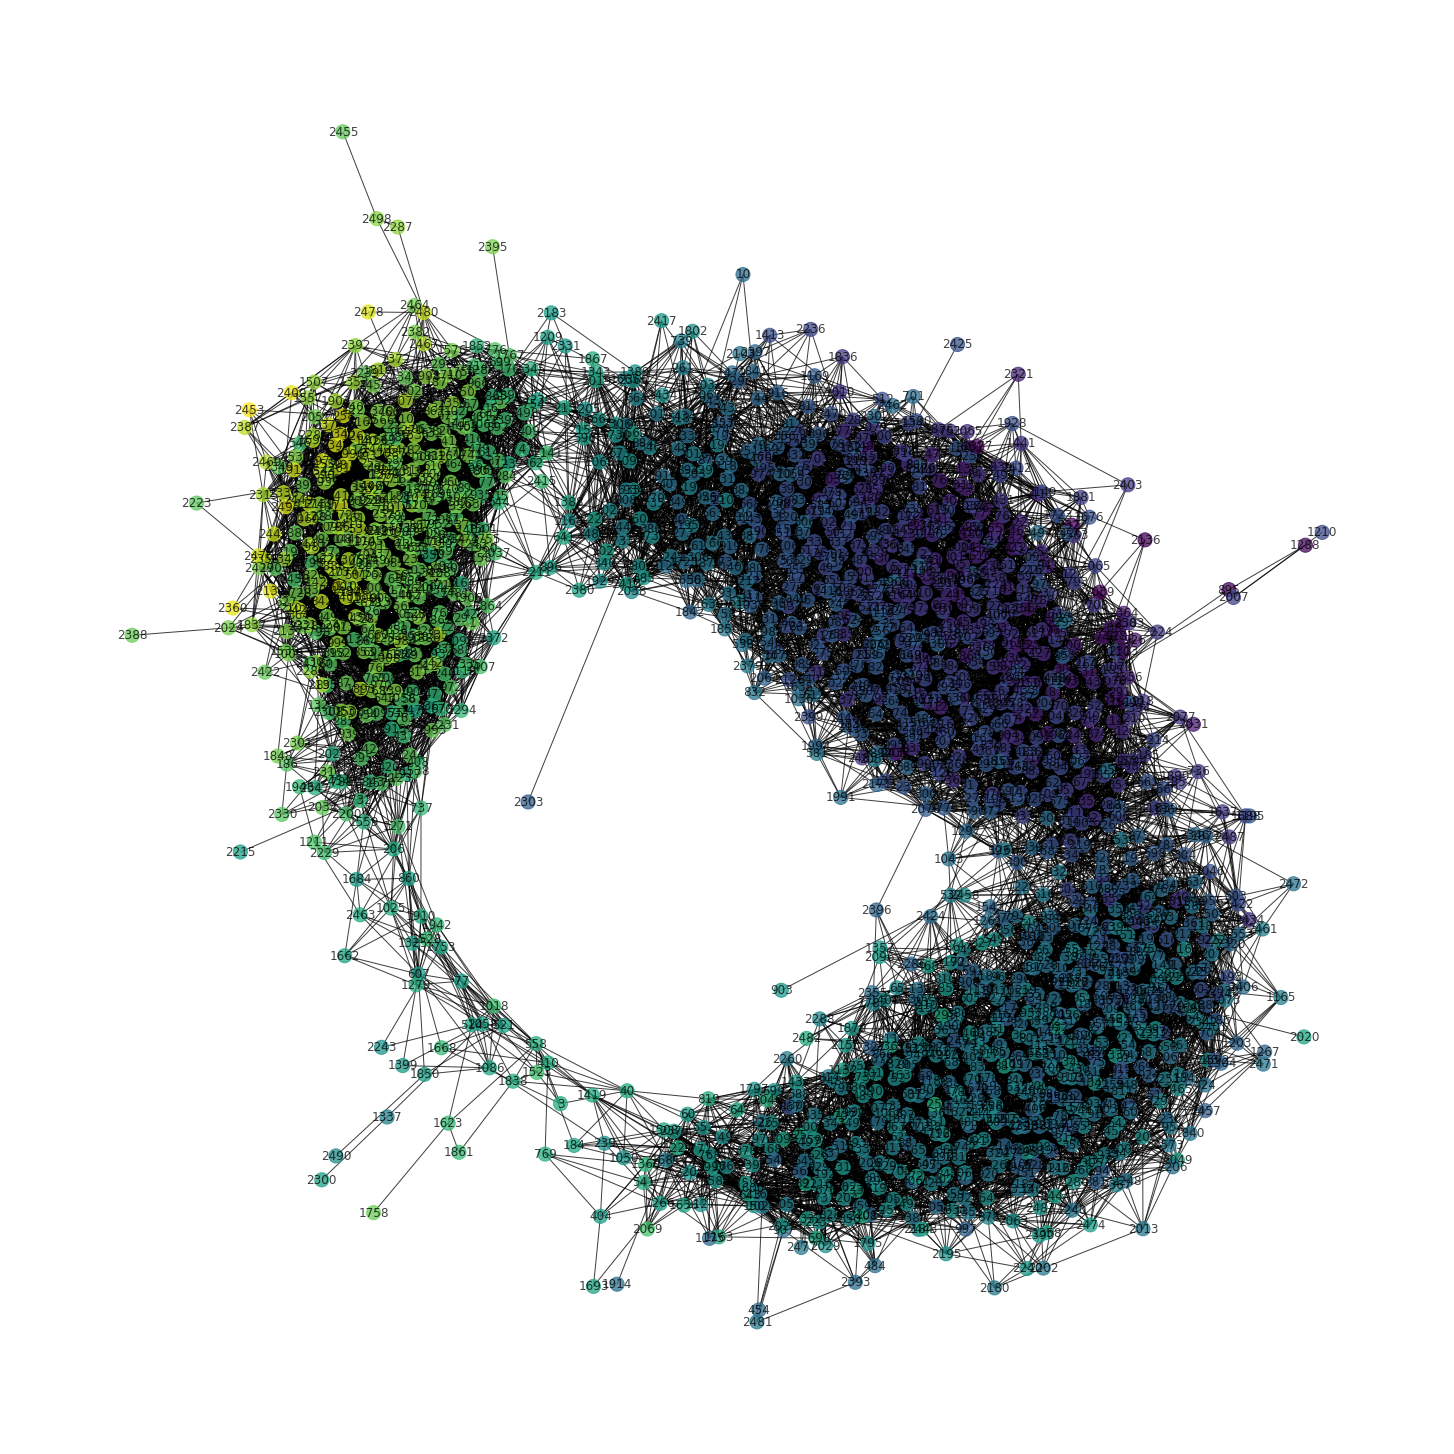

In [470]:
FIGSIZE = 20
NODESIZE = 200
plt.figure(3,figsize=(FIGSIZE,FIGSIZE)) 
# nx.draw(G, pos,with_labels=True, node_color=COH_angles,cmap="viridis", alpha=0.75)
nx.draw_networkx_edges(H, pos, alpha=0.01)
nx.draw_networkx_nodes(H, pos, alpha=0.01, node_color="k")
plt.show()

plt.figure(3,figsize=(FIGSIZE,FIGSIZE)) 
# nx.draw(G, pos,with_labels=True, node_color=COH_angles,cmap="viridis", alpha=0.75)
nx.draw_networkx_edges(H, pos, alpha=0.1)
nx.draw_networkx_nodes(H, pos, node_color=CO,
                       node_size=NODESIZE,
                       cmap="viridis",alpha=0.75)
plt.show()

plt.figure(3,figsize=(FIGSIZE,FIGSIZE)) 
# nx.draw(G, pos,with_labels=True, node_color=COH_angles,cmap="viridis", alpha=0.75)
nx.draw_networkx_edges(H, pos, alpha=0.1)
nx.draw_networkx_nodes(H, pos, node_color=COH,
                                              node_size=NODESIZE,
                       cmap="viridis",alpha=0.75)
plt.show()

# fig, ax = plt.subplots(1,figsize=(FIGSIZE,FIGSIZE)) 
# # nx.draw(G, pos,with_labels=True, node_color=COH_angles,cmap="viridis", alpha=0.75)
# nx.draw_networkx_edges(H, pos, alpha=0.1)
# nx.draw_networkx_nodes(H, pos, node_color=RMSD_to_0,
#                                               node_size=NODESIZE,
#                        label=nodes,
#                        cmap="viridis",alpha=0.75)
# plt.show()

import matplotlib as mpl
fig, ax = plt.subplots(1,figsize=(1,3)) 

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=min(RMSD_to_ref), vmax=max(RMSD_to_ref))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Some Units')

plt.show()

plt.figure(3,figsize=(FIGSIZE,FIGSIZE)) 
nx.draw(H, pos,with_labels=True, node_color=RMSD_to_ref,cmap="viridis", node_size=NODESIZE, alpha=0.75)

In [ ]:
5000000
 337342

#  Graph info

# of edges 29322


(array([ 63.,  85., 117., 124., 153., 197., 216., 244., 264., 357.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

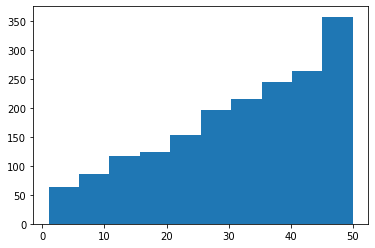

In [471]:
degree_sequence = [d for n, d in H.degree()]

degree_dict = {}
for n,d in H.degree():
    if d not in degree_dict.keys():
        degree_dict[d] = []
    degree_dict[d].append(n)
    
print("# of edges", len(H.edges()))
plt.hist(degree_sequence)

In [472]:
deg = degree_dict.keys()
deg = list(deg)
deg.sort()
deg
# print("1", degree_dict[1])
# print("2", degree_dict[2])
# print("3", degree_dict[3])
# print("9", degree_dict[9])
# print(degree_dict[216])
print(min(deg), max(deg))

1 50


In [473]:
print(len(H.nodes))

1820


#  Visualize individual conformers

In [490]:
view_mol_i(1000)

1000


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [487]:
view_mol_i(167)

167


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [476]:
view_mol_i(24)

24


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [477]:
view_mol_i(1841)

1841


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [478]:
view_mol_i(1838)

1838


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [479]:
lst, anytree = make_traversal(H, start=674)

674
├── 323
│   ├── 2078
│   │   ├── 2396
│   │   │   ├── 1782
│   │   │   │   ├── 1078
│   │   │   │   │   ├── 1437
│   │   │   │   │   │   ├── 819
│   │   │   │   │   │   │   └── 40
│   │   │   │   │   │   │       ├── 410
│   │   │   │   │   │   │       │   ├── 2058
│   │   │   │   │   │   │       │   │   └── 1337
│   │   │   │   │   │   │       │   │       └── 2300
│   │   │   │   │   │   │       │   └── 1668
│   │   │   │   │   │   │       ├── 558
│   │   │   │   │   │   │       │   ├── 1623
│   │   │   │   │   │   │       │   │   └── 1758
│   │   │   │   │   │   │       │   └── 514
│   │   │   │   │   │   │       │       └── 2243
│   │   │   │   │   │   │       ├── 1838
│   │   │   │   │   │   │       │   └── 1861
│   │   │   │   │   │   │       ├── 1523
│   │   │   │   │   │   │       └── 3
│   │   │   │   │   │   └── 1664
│   │   │   │   │   │       └── 2069
│   │   │   │   │   ├── 705
│   │   │   │   │   │   ├── 2195
│   │   │   │   │   │   └── 350
│   │   │   │   │   ├── 573
│

In [484]:
traj_path = lst[0]
animate_path(traj_path, reps=5)

Frame	Bond	Angle	RMSD
674	1.44	109.41	0.00
323	1.43	110.33	0.38
2078	1.46	107.33	0.43
2396	1.41	105.71	0.53
1782	1.42	111.69	0.51
1078	1.42	109.72	0.35
1437	1.44	114.75	0.50
819	1.45	115.35	0.47
40	1.45	111.91	0.36
410	1.45	110.54	0.42
2058	1.35	113.27	0.51
1337	1.37	106.88	0.53
2300	1.43	106.13	0.43


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [481]:
traj_path = lst[1]
animate_path(traj_path)

Frame	Bond	Angle	RMSD
674	1.44	109.41	0.00
536	1.43	110.59	0.36
666	1.40	111.26	0.25
597	1.41	107.78	0.36
2424	1.39	109.09	0.55
2355	1.44	109.56	0.47
814	1.43	106.61	0.47
226	1.40	105.04	0.45
2375	1.45	102.30	0.52
1419	1.45	105.52	0.47
521	1.43	104.81	0.44
1850	1.40	103.91	0.42
2490	1.44	98.35	0.54


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [482]:
len(nodes)

1820

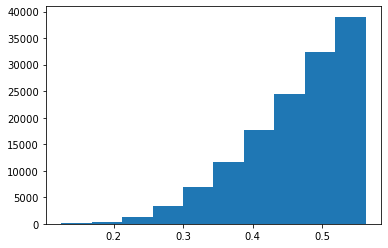

In [483]:
# plt.hist(_2drmsd.flatten())
plt.hist([_ for _ in cleaned.flatten() if _ != 0.0])
edge_labels = nx.get_edge_attributes(H, "weight")
# edge_labels[(418,847)]
# edge_labels

In [209]:
#  make xyz files
for i in nodes:
    atoms = positions[0,i]
    xyz_str = make_xyz(atoms)
    
    filename = f"rmsd2d/xyzs/p{i}.xyz"
    
    with open(filename, "w") as f:
        f.write(xyz_str)
    



In [210]:
#  make com files
header = """%chk={}
#n wB97XD/6-311g** 

job

0 1
"""

for i in nodes:
    s = header.format(f"p{ i }.chk")
    lines = open(f"rmsd2d/xyzs/p{i}.xyz").readlines()[2:]
    for _ in lines:
        _ = _.split()
        s += "{} {:.4f} {:.4f} {:.4f}\n".format(_[0], float(_[1]), float(_[2]), float(_[3]))
    s += "\n"
    with open((f"rmsd2d/coms/p{i}.com"), "w") as o:
        o.write(s)

    

In [458]:
s = "vmd"
for _ in lst[0]:
    s += f" p{_}.p.cube"
print(s)

vmd p0.p.cube p8.p.cube p35.p.cube p75.p.cube p98.p.cube p99.p.cube p97.p.cube


In [915]:
def scan_neighbours_schedule_from_anytree_graph(anytree, G):
    """
    Scan recursively through the tree, starting from the root
    """
    order = []

    def scan_children(node):
        if len(node.children) > 0:
            children = node.children
            for c in children:
                order.append([node.name, c.name])
                if len(c.children) > 0:
                    scan_children(c)
        else:
            pass

    scan_children(anytree)

    # print_anytree(anytree)

    scan_neighbours_schedule = []
    visited = []
    for i in order:
        start, end = tuple(i)
        if len(visited) == 0:
            previous = order[0][0]
        else:
            previous = [x for x in visited if x[1] == start][0]
        neighbours = [x for x in G.edges(start) if x[1] != end]
        schedule = [tuple(x) for x in order if x[0] == end]
        scan_neighbours_schedule.append(((previous, start, end), neighbours, schedule))

    return scan_neighbours_schedule


def print_anytree(anytree):
    for pre, fill, node in RenderTree(anytree):
        print(f"{pre}{node.name}")
        
        

In [434]:
_ = scan_neighbours_schedule_from_anytree_graph(anytree, H)

NameError: name 'scan_neighbours_schedule_from_anytree_graph' is not defined

In [435]:
import pickle

In [436]:
filehandler = open(b"anytree.obj","wb")
pickle.dump(anytree,filehandler)

In [437]:
filehandler = open(b"H.obj","wb")
pickle.dump(H,filehandler)

In [429]:
# gg = pd.read_pickle("G.obj")
# gg

In [438]:
filehandler = open(b"RMSD_to_ref.obj","wb")
pickle.dump(RMSD_to_ref,filehandler)

In [404]:
# for a,b in zip(H.nodes(), RMSD_to_ref):
#     print(a,b)